# Burn radius scaling

The radius around ground zero that burns is very uncertain. The best we can do is start from Hiroshima/Nagasaki and scale from there. But how should we scale? Toon et al. scale as $\sqrt{Y}$, and they cite [this](https://www.ncbi.nlm.nih.gov/books/NBK219184/) as the source. What that source actually talks about is the radius at which spontaneous ignition occurs due to radiation heating from the fireball. That's easy to understand: this is just the good old $1/D^2$ scaling law. But this is only valid in a vacuum. In a real atmosphere, the fireball will be surrounded by air, and the radiation will be absorbed by the air.

[The effects of nuclear weapons](https://www.atomicarchive.com/resources/documents/pdfs/effects/effects7.pdf) gives a better formula, which is essentially $Q \propto T(D) Y / D^2$. $T(D)$ is the transmittance of the atmosphere and of course it also depends on the height of the burst. But for our nominal 100kt, Nukemap says it's 1.5km to maximize blast damage. So using that value I can extract the $T(D)$ values from the figure in the book.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [24]:
distance = np.array([0.6, 1.96, 3.49, 6.64, 9.58, 12.8])
transmittance = np.array([0.9, 0.8, 0.7, 0.6, 0.5, 0.4])
# transmittance = np.ones(len(distance))

[-2.10824888  0.85160726]


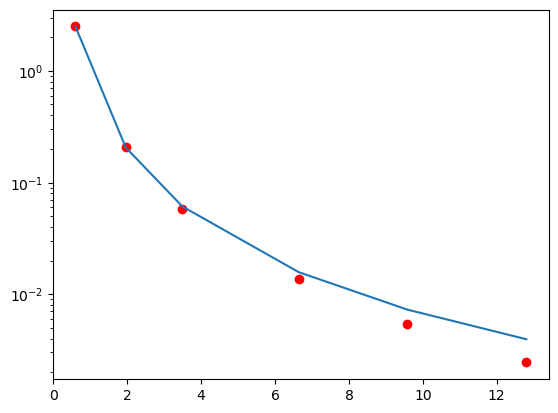

In [26]:
# Fit a power law function to the data
def power_law(x, a, b):
    return x**a * b

popt, pcov = curve_fit(power_law, distance, transmittance/distance**2)
print(popt)

plt.semilogy(distance, transmittance/distance**2, 'or')
plt.semilogy(distance, power_law(distance, *popt))
plt.show()

So that would mean that the thermal radius scales like $D^{0.47}$, which is very close to $D^{0.5}$. For a 100kt weapon, that's difference of just ~5% for the burn radius assuming we scale from Hiroshima's 15kt value. But it's important to note that these values are for a clear day: the difference increases if the visibility is reduced.

But then there is a [claim](https://forum.effectivealtruism.org/posts/Ysq53coRwgSWHHz2x/nuclear-winter-scepticism) that we should maybe actually be using the overpressure radius, which would mean using $D^{1/3}$ instead.